In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KASHISH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df=pd.read_csv(r"C:\Users\KASHISH\Downloads\spam.csv",encoding='latin-1')[['v1','v2']]
df.columns=['label','message']


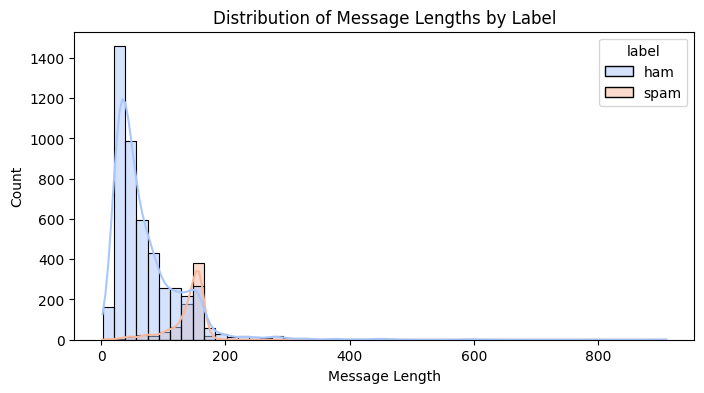

In [3]:

df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='message_length', hue='label', palette='coolwarm', bins=50, kde=True)
plt.xlabel("Message Length")
plt.title("Distribution of Message Lengths by Label")
plt.show()


In [4]:
print(df.head())

  label                                            message  message_length
0   ham  Go until jurong point, crazy.. Available only ...             111
1   ham                      Ok lar... Joking wif u oni...              29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...             155
3   ham  U dun say so early hor... U c already then say...              49
4   ham  Nah I don't think he goes to usf, he lives aro...              61


In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           5572 non-null   object
 1   message         5572 non-null   object
 2   message_length  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB
None


In [6]:
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [7]:
df = df.dropna() 

In [8]:
df['label']=df['label'].map({'ham':0,'spam':1})


C:\Users\KASHISH\AppData\Local\Temp\ipykernel_15744\767417919.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='coolwarm')


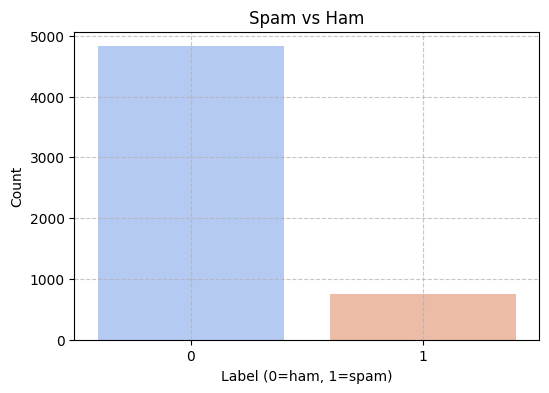

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette='coolwarm')
plt.xlabel("Label (0=ham, 1=spam)")
plt.ylabel("Count")
plt.title("Spam vs Ham")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [10]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)
df['cleaned_message']=df['message'].apply(preprocess_text)

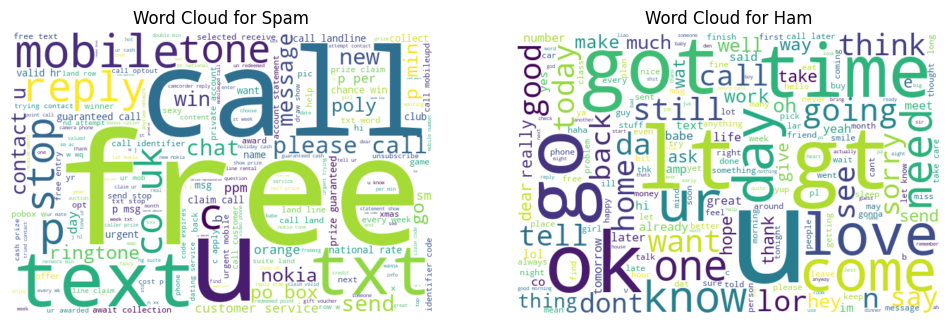

In [11]:
spam_words = ' '.join(list(df[df['label'] == 1]['cleaned_message']))
ham_words = ' '.join(list(df[df['label'] == 0]['cleaned_message']))

spam_wc = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
ham_wc = WordCloud(width=600, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.title("Word Cloud for Spam")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.title("Word Cloud for Ham")
plt.axis("off")
plt.show()

In [12]:
vectorizer=TfidfVectorizer(max_features=3000)
X=vectorizer.fit_transform(df['cleaned_message']).toarray()
y = df['label'].values

In [13]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", l

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True)
}

In [22]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc_score = auc(*roc_curve(y_test, y_proba)[0:2]) if y_proba is not None else None
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"AUC: {auc_score:.2f}" if auc_score else "AUC: Not available for SVM")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Naive Bayes Performance:
Accuracy: 0.98
AUC: 1.00
[[950  35]
 [  6 939]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       985
           1       0.96      0.99      0.98       945

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930


Logistic Regression Performance:
Accuracy: 0.99
AUC: 1.00
[[973  12]
 [ 14 931]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       985
           1       0.99      0.99      0.99       945

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Random Forest Performance:
Accuracy: 0.99
AUC: 1.00
[[982   3]
 [  7 938]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       985
     

In [17]:
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]
auc_best = auc(*roc_curve(y_test, y_proba_best)[0:2])

print("\nBest Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print(f"AUC: {auc_best:.2f}")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best parameters: {'C': 100}

Best Logistic Regression Model Performance:
Accuracy: 1.00
AUC: 1.00
[[981   4]
 [  0 945]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       985
           1       1.00      1.00      1.00       945

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



In [18]:
voting_clf = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
y_proba_voting = voting_clf.predict_proba(X_test)[:, 1]
auc_voting = auc(*roc_curve(y_test, y_proba_voting)[0:2])

print("\nVoting Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.2f}")
print(f"AUC: {auc_voting:.2f}")
print(confusion_matrix(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))


Voting Classifier Performance:
Accuracy: 0.99
AUC: 1.00
[[981   4]
 [  8 937]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       985
           1       1.00      0.99      0.99       945

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



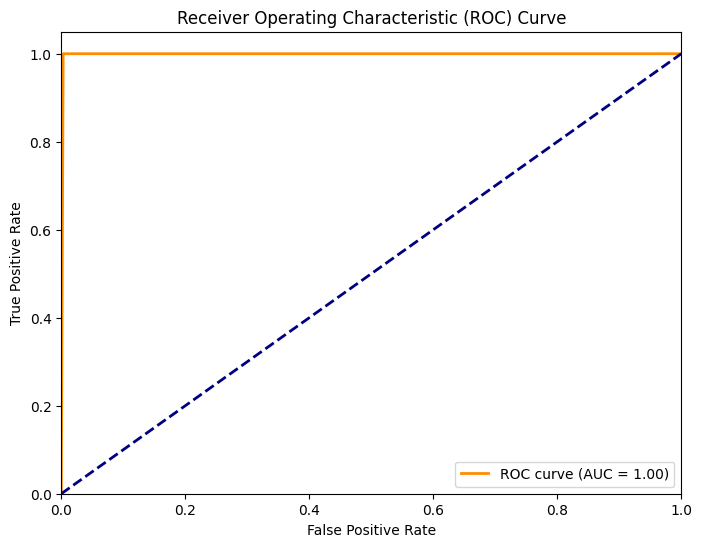

In [21]:
from sklearn.metrics import roc_curve ,auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()